In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
conn = engine.connect()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)
inspector.get_table_names()
m = inspector.get_columns('Measurement')
for column in m:
    print(column['name'], column['type'])

m = pd.read_sql('SELECT * from Measurement', conn)
m.head()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
from dateutil.relativedelta import relativedelta
#Prior year start/end dates
from time import strptime


startdate = '2011-01-01'
enddate = '2011-12-31'

#Convert from string to date format
start_dt = (dt.datetime.strptime(startdate, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(enddate, "%Y-%m-%d")).date()

# Prior Year
startdate_py = start_dt - relativedelta(years=1)
enddate_py = end_dt - relativedelta(years=1)


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
print(calc_temps('2011-01-01', '2011-12-31'))
my_trip_data = calc_temps('2011-01-01', '2011-12-31')


[(56.0, 72.67471642883278, 86.0)]


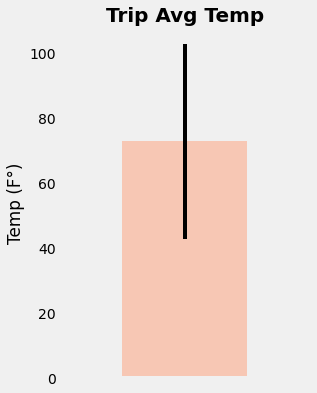

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df = pd.DataFrame(my_trip_data, columns=['Min_Temp', 'Avg_Temp', 'Max_Temp'])
my_trip_df
# print(my_trip_df)
avg_tmp = my_trip_df['Avg_Temp']
min_max = my_trip_df.iloc[0]['Max_Temp'] - my_trip_df.iloc[0]['Min_Temp']
avg_tmp.plot(kind='bar', yerr=min_max, figsize=(4,6), alpha=0.5, color='lightsalmon')
plt.title('Trip Avg Temp', fontsize=20, fontweight='bold')
plt.ylabel('Temp (F°)')
plt.xticks([])
plt.grid()
plt.savefig('../sqlalchemy_challenge/Images/tom_trip.png')
plt.show()

### Daily Rainfall Average

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
daily_rainfall_avg=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp), Station.latitude,Station.longitude,Station.elevation).\
    filter(Measurement.date >= startdate_py).\
    filter(Measurement.date <= enddate_py).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all())

daily_rainfall_avg_df = pd.DataFrame(daily_rainfall_avg, columns=['station', 'name', 'prcp', 'latitude', 'longitude', 'elevation' ])
daily_rainfall_avg_df

,station,name,prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",135.32,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",65.69,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",40.63,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",34.41,21.33556,-157.71139,19.5
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",33.14,21.49920,-158.01110,306.6
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",25.76,21.52130,-157.83740,7.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.33,21.31520,-157.99920,0.9
7,USC00519397,"WAIKIKI 717.2, HI US",9.86,21.27160,-157.81680,3.0
8,USC00517948,"PEARL CITY, HI US",5.24,21.39340,-157.97510,11.9


### Daily Temperature Normals

In [28]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-08")

[(57.0, 67.16071428571429, 75.0)]

In [70]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip
start_date = '2011-01-01'
end_date = '2011-01-10'

# Use the start and end date to create a range of dates

trip_dates = pd.date_range(start_date, end_date)
trip_dates

# Strip off the year and save a list of strings in the format %m-%d

trip_dates_mm_dd = trip_dates.strftime('%m-%d')
print(trip_dates_mm_dd)

# # Use the `daily_normals` function to calculate the normals for each date string 
# # and append the results to a list called `normals`.
for i in trip_dates_mm_dd:
    normals.append(*daily_normals(i))
# print(normals)

Index(['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07', '01-08',
       '01-09', '01-10'],
      dtype='object')


In [71]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(normals, columns=['min_temp', 'avg_temp', 'max_temp'], index=trip_dates)

trip_normals_df.index.name='date'
trip_normals_df.reset_index()


,date,min_temp,avg_temp,max_temp
0,2011-01-01,62.0,69.153846,77.0
1,2011-01-02,60.0,69.396226,77.0
2,2011-01-03,62.0,68.909091,77.0
3,2011-01-04,58.0,70.000000,76.0
4,2011-01-05,56.0,67.964286,76.0
5,2011-01-06,61.0,68.964912,76.0
6,2011-01-07,57.0,68.543860,76.0
7,2011-01-08,57.0,67.160714,75.0
8,2011-01-09,58.0,67.929825,78.0
9,2011-01-10,62.0,69.741379,77.0


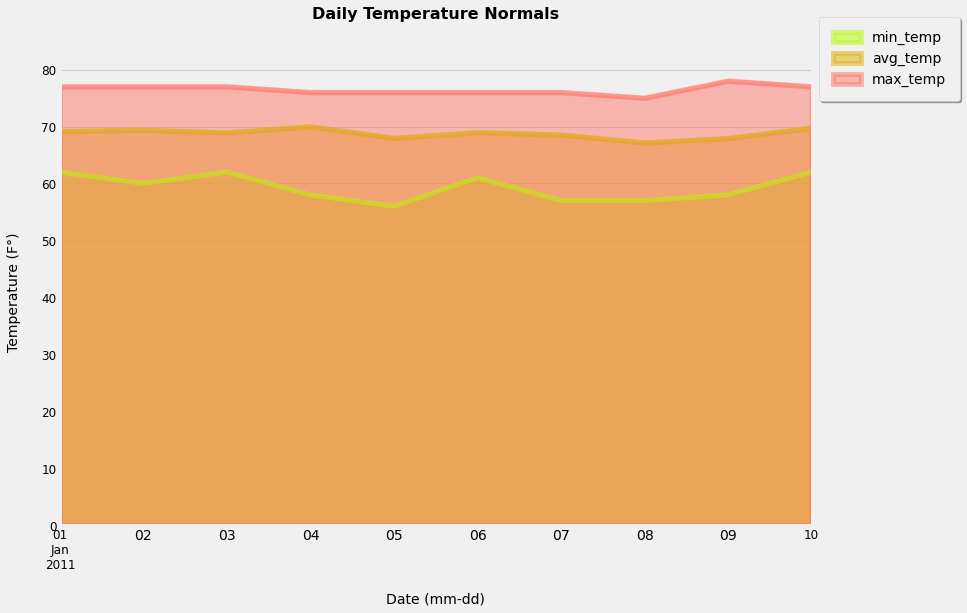

In [72]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rcParams['figure.figsize']=(12,8)
colors = ['xkcd:yellowgreen', 'xkcd:gold', 'xkcd:salmon']
trip_normals_df.plot.area(linewidth=5,stacked=False,rot=0,alpha=0.5,color=colors)
plt.ylim=(-5, 100)
plt.yticks(size=12)
plt.xticks(fontsize=12)
plt.xlabel('Date (mm-dd)', fontsize=14, color='black', labelpad=20)
plt.ylabel('Temperature (F°)', fontsize=14, color='black', labelpad=20)
plt.title('Daily Temperature Normals', fontsize=16, fontweight='bold', pad=40)
plt.gca().legend(loc='center left', bbox_to_anchor=(1.00, 1.00), shadow=True, borderpad=1);


## Close Session

In [74]:
session.close()